# Technical Document Content

#### 1. Exploratory Data Analysis
#### 2. Data Preparation
#### 3. Modelling

# 1. Exploratory Data Analysis

To better understand the data, we did EDA on the following content:

**I. Import package and read dataset**

**II. Summary statistics**
  - (a) Sales
      - 1. category
      - 2. department
      - 3. state
  - (b) Price
  - (c) Calendar
  
**III. Time Series Analysis**
  - (a) Rolling mean sales trend
  - (b) Cross sales distribution
  - (c) Average price trend
  - (d) Total sales trend
  - (e) Sales distribution accross store
  - (f) Sales distribution accross category 

## I. Import package and read dataset

In [2]:
import pandas as pd
import csv
import datetime as datetime
import json 
import datetime as dttm
import sklearn
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pylab as plab

### View interactive plotly in jupyter notebook
# import plotly.offline as pyo
# import plotly.graph_objs as go
# from plotly.offline import init_notebook_mode, iplot
# pyo.init_notebook_mode(connected=True) 
# import plotly.io as pio
# pio.renderers.default='notebook'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

In [4]:
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
sales_train = pd.read_csv('sales_train_validation.csv')

## II. Summary statistics

## (a) Sales

* The raw data is down to item_id level with **30490 items in 1913 daily sales** across different categories, stores and states.
* Many values in the time series are zero which indicates the **intermittent demand** for time series.

In [5]:
sales_train.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### 1. State

There are 3 states - **4 in CA, 3 in WI, and 3 in TX.** California has 40% of items in total, which is the highest one.

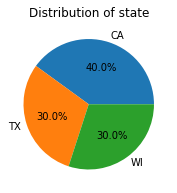

In [6]:
state = sales_train['state_id'].value_counts().sort_index() / sales_train['state_id'].value_counts().sum() * 100
fig = plt.figure(figsize=(3, 3))
plt.pie(state, labels=state.index, autopct='%1.1f%%')
plt.title('Distribution of state')
plt.show()

### 2. Store

Within each state with 3049 items in each store, there are 10 stores such as CA_1, CA_2, CA_3, and CA_4 in California.

### 3. Category

There are 3 categories: **Hobbies, Household and Foods**. Within each categories, Foods accounts for almost half of the sales.

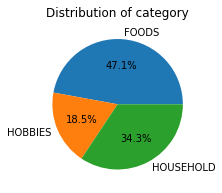

In [7]:
cat = sales_train['cat_id'].value_counts().sort_index() / sales_train['cat_id'].value_counts().sum() * 100
fig = plt.figure(figsize=(3, 3))
plt.pie(cat, labels=cat.index, autopct='%1.1f%%')
plt.title('Distribution of category')
plt.show()

In [27]:
sales_prods = sales_train.loc[:, 'd_1' : ]

# zero value in sales
zero = sales_prods.apply(lambda x: x == 0)
z = zero.sum(axis=1)
z = z/1913
sales_train['zero_days'] = z

# By category
hobbies = sales_train.loc[sales_train['cat_id']=='HOBBIES']
foods = sales_train.loc[sales_train['cat_id']=='FOODS']
household = sales_train.loc[sales_train['cat_id']=='HOUSEHOLD']

# Plot histogram
fig = go.Figure()
fig.add_trace(go.Histogram(x=hobbies['zero_days'],name='Hobbies'))
fig.add_trace(go.Histogram(x=foods['zero_days'],name='Foods'))
fig.add_trace(go.Histogram(x=household['zero_days'],name='Household'))
fig.update_layout(barmode='overlay',title_text='Distribution of Zero Values Across Categories',
                  xaxis_title_text='Proportion of 0 in sales', yaxis_title_text='Count of dates')
fig.update_traces(opacity=0.5)
fig.show()

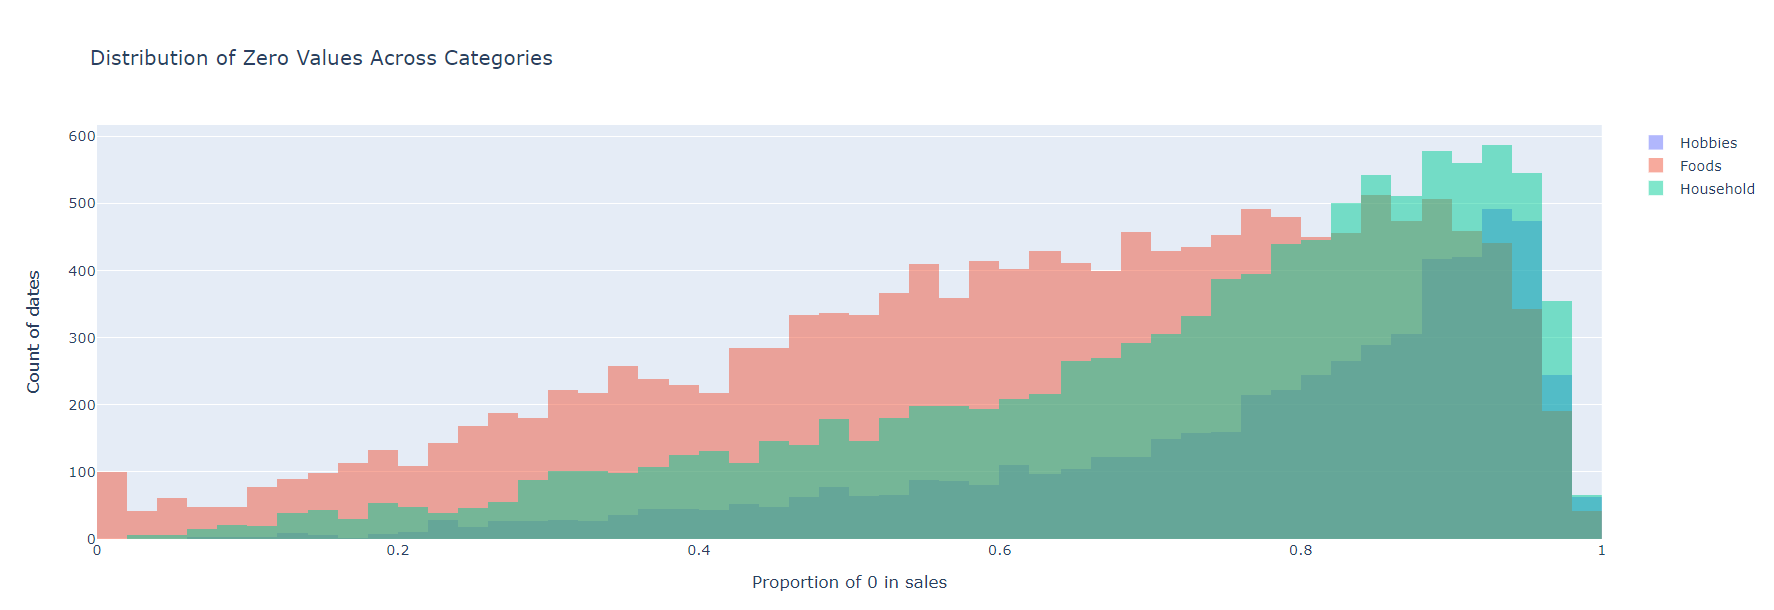

In [29]:
from IPython.display import Image
Image("zeroval.png")

### 4. Department

Within 7 departments, Foods_3 has about 8000 number of items in total, which is the highest one.

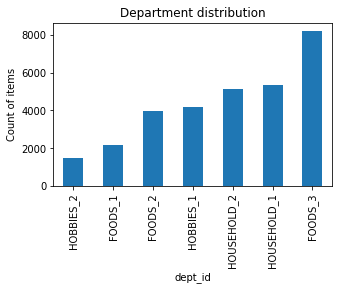

In [9]:
sales_train.groupby('dept_id').count()['id'].sort_values().plot(kind = 'bar', 
                                                                figsize=(5, 3), title='Department distribution',
                                                                ylabel = 'Count of items')
plt.show()

## (b) Prices

Sell_prices dataset is about daily price for 3049 items in the sales_train dataset across 10 stores.

In [10]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


## (c) Calendar

- Calendar dataset contains: different time series levels such as date, month and year, event fields to mark the special holidays and their types, and snap day(Supplemental Nutritional Assistance Program) which refers to purchasing activity of low income households.
- It contains 1969 unique dates and all can be matched with sales_train dataset.

In [11]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## III. Time series analysis

### (a) Rolling mean sales trend

In [12]:
dcols = [d for d in sales_train.columns if 'd_' in d]
past_sales = sales_train.set_index('id')[dcols].T.merge(calendar.set_index('d')['date'],
                                                        left_index = True, right_index = True, validate = '1:1').set_index('date')

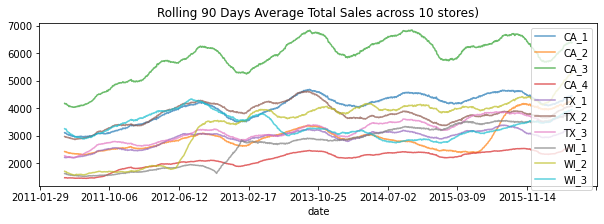

In [13]:
store_list = sell_prices['store_id'].unique()

for s in store_list:
    store_items = [p for p in past_sales.columns if s in p]
    past_sales[store_items].sum(axis=1).rolling(90).mean().plot(figsize=(10, 3),
              alpha=0.7, title='Rolling 90 Days Average Total Sales across 10 stores)')
plt.legend(store_list)
plt.show()

### (b) Cross sales distribution

In [14]:
sales_train['total_sales'] = sales_train[dcols].sum(axis=1)

Text(0.5, 14.09375, 'dept_id')

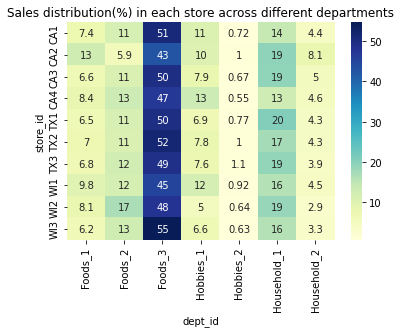

In [15]:
dist = sales_train.groupby(['store_id','dept_id']).agg({"total_sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
distplt = sns.heatmap(dist, annot=True, cmap="YlGnBu",
                xticklabels =['Foods_1','Foods_2','Foods_3','Hobbies_1','Hobbies_2','Household_1','Household_2'],
                yticklabels = ['CA1','CA2','CA3','CA4','TX1','TX2','TX3','WI1','WI2','WI3'])
plt.title("Sales distribution(%) in each store across different departments")
plt.xlabel('dept_id')

### (c) Average price trend

In [16]:
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
sales_train = pd.read_csv('sales_train_validation.csv')

In [17]:
cols = ['date','wm_yr_wk','d','weekday','month','year','event_type_1','snap_CA','snap_TX','snap_WI']
calendar_1 = calendar[cols]

In [18]:
rows=int(sales_train.shape[0]/4)
sales_train=sales_train.sample(rows, replace=True)
sales_train_l=sales_train.melt(['id','item_id','dept_id','cat_id','store_id','state_id'], var_name='d', value_name='qty')

sales_train_2 = pd.merge(left=sales_train_l,right=calendar_1,left_on='d', right_on='d')
sales_train_2['event_type_1']=sales_train_2['event_type_1'].fillna('No Event')
sales_train_3 = pd.merge(left=sales_train_2,right=sell_prices,left_on=['store_id','item_id','wm_yr_wk'],right_on=['store_id','item_id','wm_yr_wk'])

In [30]:
# average price
price_cat = sales_train_3.groupby(['date','cat_id'],as_index=False)['sell_price'].mean().dropna()
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Scatter(x=price_cat[price_cat['cat_id']=='HOBBIES']['date'], 
                         y=price_cat[price_cat['cat_id']=='HOBBIES']['sell_price'],name='HOBBIES'), row=1, col=1)
fig.add_trace(go.Scatter(x=price_cat[price_cat['cat_id']=='HOUSEHOLD']['date'],
               y=price_cat[price_cat['cat_id']=='HOUSEHOLD']['sell_price'],name='HOUSEHOLD'),row=1, col=2)
fig.add_trace(go.Scatter(x=price_cat[price_cat['cat_id']=='FOODS']['date'],
                         y=price_cat[price_cat['cat_id']=='FOODS']['sell_price'],name='FOODS'),row=1, col=3)

fig.update_layout(title_text='Average Price in 3 categories',yaxis_title_text='Price',width=800, height=400)
fig.show()

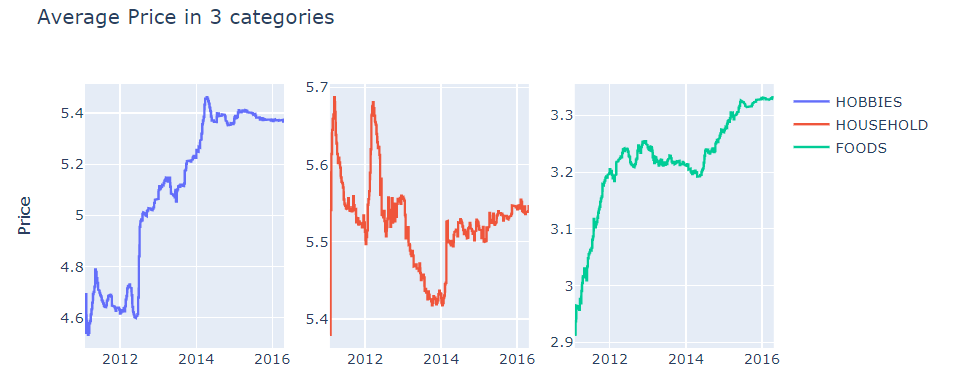

In [31]:
from IPython.display import Image
Image("price.png")

In [20]:
### aggregation
# State
state= sales_train_3.groupby(['state_id','date']).agg({'qty': ['mean']}).reset_index()
state.columns=['state_id','date','qty']

# dept
dept_sales=sales_train_3.groupby(['dept_id','date']).agg({'qty': ['sum']}).reset_index()
dept_sales.columns=['dept_id','date','qty']

# category
cat=sales_train_3.groupby(['cat_id','date']).agg({'qty': ['mean']}).reset_index()
cat.columns=['cat_id','date','qty']

### yearly
# state
year_state=sales_train_3.groupby(['year','state_id']).agg({'qty': ['mean']}).reset_index()
year_state.columns=['year','state_id','qty']

# store
store=sales_train_3.groupby(['store_id','year']).agg({'qty': ['mean']}).reset_index()
store.columns=['store_id','date','qty']

# state
weekday_state=sales_train_3.groupby(['weekday','state_id']).agg({'qty': ['mean']}).reset_index()
weekday_state.columns=['weekday','state_id','qty']


### monthly
month=sales_train_3.groupby(['month']).agg({'qty': ['mean']}).reset_index()
month.columns=['month','qty']

# state
month_state=sales_train_3.groupby(['month','state_id']).agg({'qty': ['mean']}).reset_index()
month_state.columns=['month','state_id','qty']

### (d) Total sales trend

In [32]:
fig = go.Figure()
dept_list=['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2','HOUSEHOLD_1', 'HOUSEHOLD_2']

for d in range(7):
  subset = dept_sales[dept_sales['dept_id']==dept_list[d]]
  fig.add_trace(go.Scatter(x=subset['date'], y=subset['qty'], mode='lines',name=dept_list[d]))

fig.update_layout(title='Total sales amount in 7 departments by date',xaxis_title_text='Date',yaxis_title_text='Sales')
fig.show()

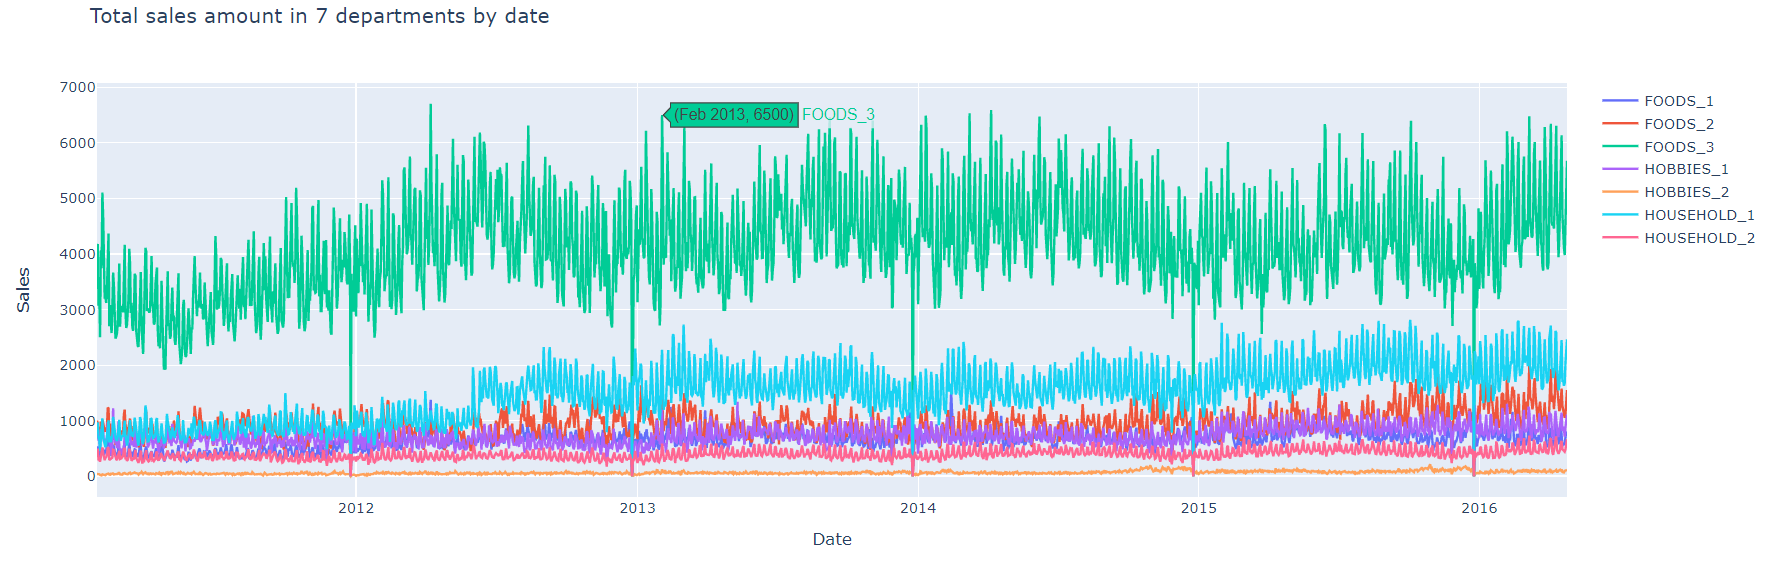

In [33]:
from IPython.display import Image
Image("dept.png")

In [35]:
fig = go.Figure()
state_list=['CA','TX','WI']

for s in range(3):
  subset=state[state['state_id']==state_list[s]]
  fig.add_trace(go.Scatter(x=subset['date'], y=subset['qty'], mode='lines', name=state_list[s]))

fig.update_layout(title='Total sales amount in 3 states by date',xaxis_title_text='Year',yaxis_title_text='Sales')
fig.show()

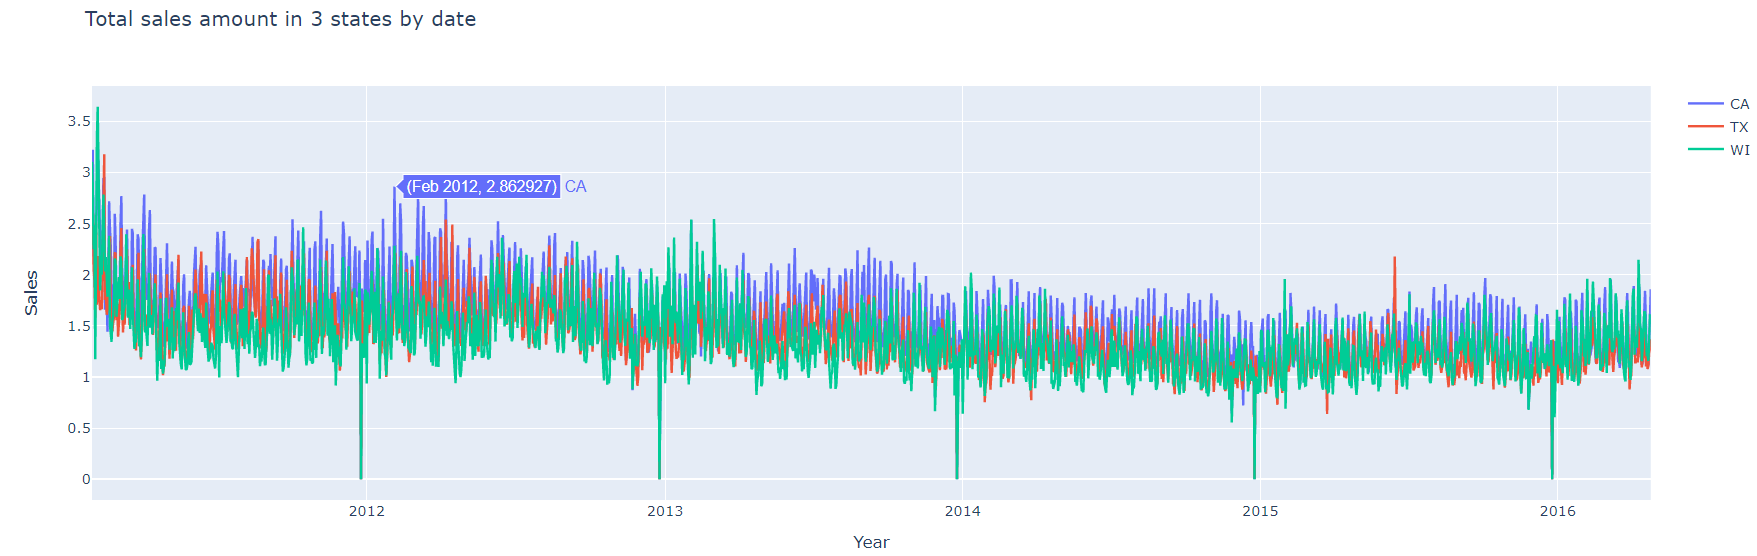

In [34]:
from IPython.display import Image
Image("state.png")

### (e) Sales distribution accross store

In [38]:
fig = go.Figure()
state_list=['CA','TX','WI']

# By year
for s in range(3):
  subset=year_state[year_state['state_id']==state_list[s]]
  fig.add_trace(go.Scatter(x=subset['year'], y=subset['qty'], mode='lines', name=state_list[s]))

fig.update_layout(title='Sales Trend in 3 states by year',xaxis_title_text='Year',yaxis_title_text='Sales',
                  width=400, height=400)
fig.show()

# By month
fig = go.Figure()
for s in range(3):
  subset=month_state[month_state['state_id']==state_list[s]]
  fig.add_trace(go.Scatter(x=subset['month'], y=subset['qty'],mode='lines',name=state_list[s]))

fig.update_layout(title='Sales Trend in 3 states by month', xaxis_title_text='Month',yaxis_title_text='Sales', width=400, height=400)
fig.show()

# By weekday
fig = go.Figure()
for s in range(3):
  subset=weekday_state[weekday_state['state_id']==state_list[s]]
  fig.add_trace(go.Bar(x=subset['weekday'], y=subset['qty'], name=state_list[s]))
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.update_layout(title='Sales Trend in 3 states by weekday',xaxis_title_text='Weekday',yaxis_title_text='Sales',
                  width=400, height=400)
fig.show()

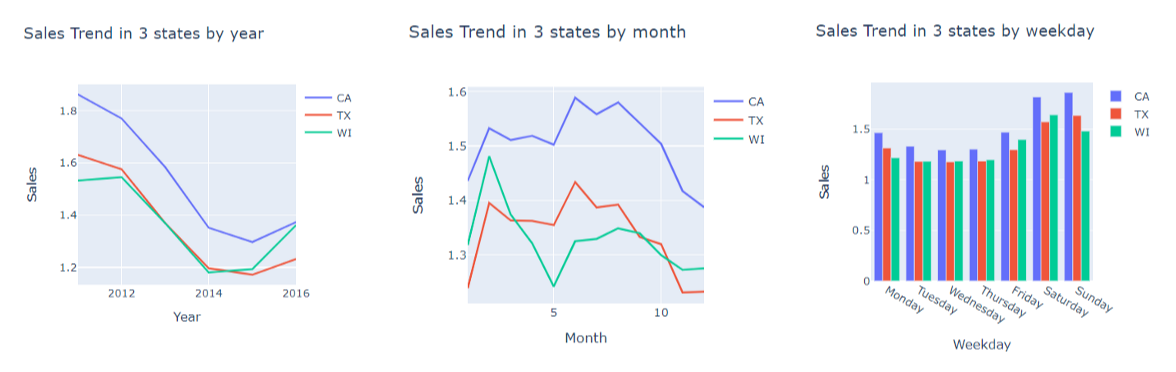

In [37]:
from IPython.display import Image
Image("state_3.png")

In [40]:
qty_cat = sales_train_3.groupby(['year','date','state_id','store_id'],as_index=False)['qty'].sum().dropna()

fig = px.box(qty_cat, x='store_id', color='state_id',y='qty') 
fig.update_layout(template='seaborn',title='Total sales amount distribution for 10 stores',legend_title_text='State'
                  ,yaxis_title="sales amount")

fig.show()

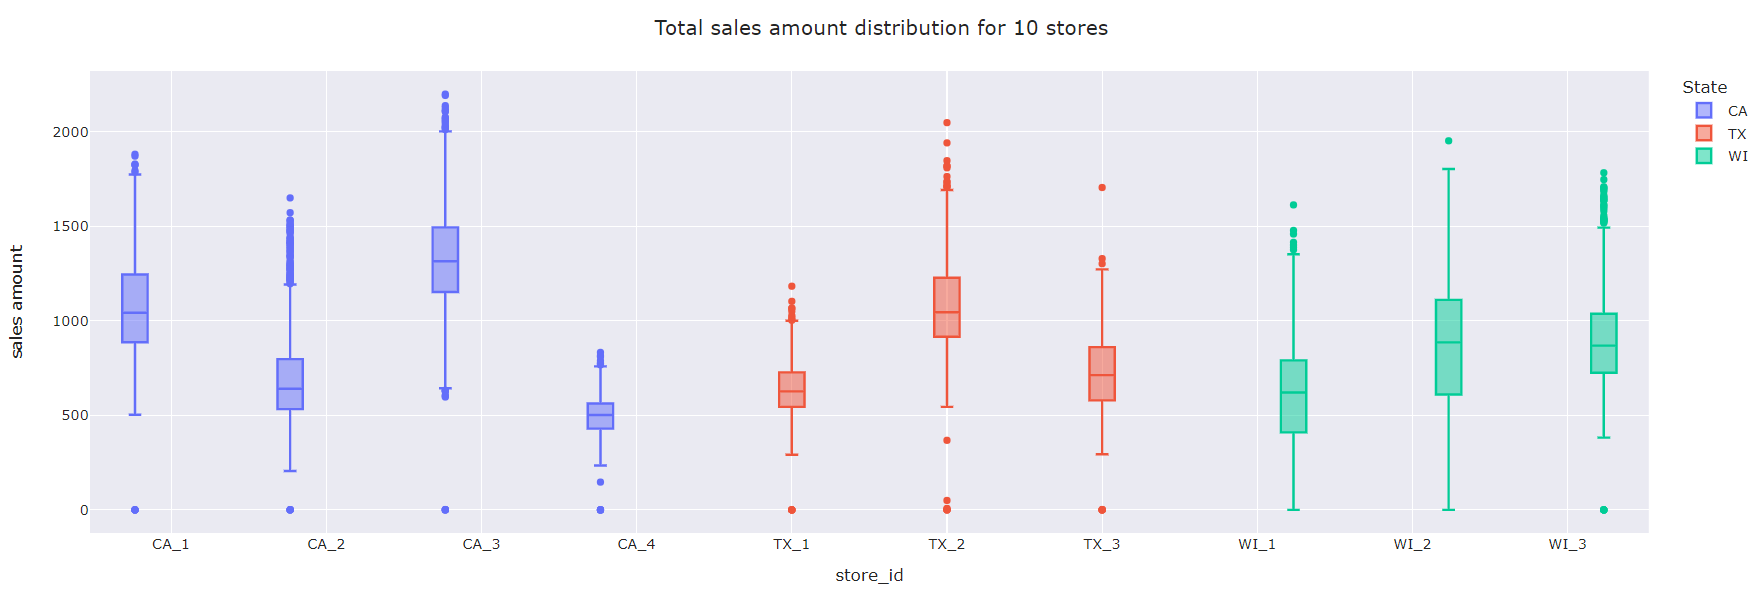

In [39]:
from IPython.display import Image
Image("store.png")

### (f) Sales distribution accross category

In [25]:
cat_level = sales_train.groupby("cat_id")[dcols].sum().reset_index().set_index('cat_id').T
base = datetime.datetime(2011,1,29)
cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
cat_level.set_index('datum', drop=True, inplace=True)
cat_level.sort_index(inplace=True)

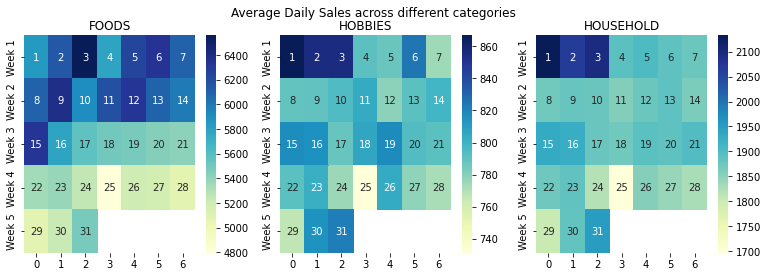

In [26]:
cat_monthly_sales = cat_level.groupby(cat_level.index.strftime('%d')).mean()
foods_list = np.array(cat_monthly_sales['FOODS'].tolist())
foods_list = np.append(foods_list, np.repeat(np.nan, 4)).reshape(5,7)
hobbies_list = np.array(cat_monthly_sales['HOBBIES'].tolist())
hobbies_list = np.append(hobbies_list, np.repeat(np.nan, 4)).reshape(5,7)
household_list = np.array(cat_monthly_sales['HOUSEHOLD'].tolist())
household_list = np.append(household_list, np.repeat(np.nan, 4)).reshape(5,7)
labels = range(1,32)
labels = np.append(labels, np.repeat(np.nan, 4)).reshape(5,7)

fig, (ax1, ax2 , ax3) = plt.subplots(1,3)
fig.set_size_inches(13, 4, forward=True)
foods_map= sns.heatmap(foods_list,cmap = "YlGnBu",annot = labels, yticklabels = ("Week 1","Week 2","Week 3","Week 4","Week 5"), ax =ax1)
hobbies_map= sns.heatmap(hobbies_list,cmap = "YlGnBu",annot = labels, yticklabels = ("Week 1","Week 2","Week 3","Week 4","Week 5"), ax =ax2)
household_map= sns.heatmap(household_list,cmap = "YlGnBu",annot = labels, yticklabels = ("Week 1","Week 2","Week 3","Week 4","Week 5"), ax =ax3)
ax1.set_title('FOODS')
ax2.set_title('HOBBIES')
ax3.set_title('HOUSEHOLD')

plt.suptitle("Average Daily Sales across different categories ")
plt.show()

# 2. Data Preparation

**I. Original features**

**II. Add new features**

**III. Feature Importance**

In [ ]:
%pip install -qqq mlforecast

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
from mlforecast import Forecast
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import seasonal_rolling_mean, rolling_mean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_path = Path('/content/drive/Shared drives/Predictive Project/Data/')

## I. Original feature

- Import Calendat, price, and sales data set

In [ ]:
cal_dtypes = {
    'd': 'category',
    'wm_yr_wk': np.uint16,
    'event_name_1': 'category',
    'event_type_1': 'category',
    'event_name_2': 'category',
    'event_type_2': 'category',
    'snap_CA': np.uint8,
    'snap_TX': np.uint8,
    'snap_WI': np.uint8,
}
cal = pd.read_csv(input_path / 'calendar.csv', 
                  dtype=cal_dtypes, 
                  usecols=list(cal_dtypes.keys()) + ['date'], 
                  parse_dates=['date'])
event_cols = [k for k in cal_dtypes if k.startswith('event')]
for col in event_cols:
    cal[col] = cal[col].cat.add_categories('nan').fillna('nan')

In [ ]:
prices_dtypes = {
    'store_id': 'category',
    'item_id': 'category',
    'wm_yr_wk': np.uint16,
    'sell_price': np.float32
}
prices = pd.read_csv(input_path / 'sell_prices.csv', dtype=prices_dtypes)

In [ ]:
sales_dtypes = {
    'id': 'category',
    'item_id': prices.item_id.dtype,
    'dept_id': 'category',
    'cat_id': 'category',
    'store_id': 'category',
    'state_id': 'category',
    **{f'd_{i}': np.float32 for i in range(1942)}
}
sales = pd.read_csv(
    input_path / 'sales_train_evaluation.csv',
    dtype=sales_dtypes,
)

- Pre-process, merge the three data sets and change it to long format

In [ ]:
old = sales.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='y'
)

old['d'] = old['d'].astype(cal.d.dtype)
old = old.merge(cal, on=['d'])
old = old.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'])

old['date_idx'] = old['d'].str.replace('d_', '').astype('int32')
dates = sorted(old['date_idx'].unique())
old = old.sort_values(['id', 'date_idx'])
without_leading_zeros = old['y'].gt(0).groupby(old['id']).transform('cummax') # remove evaluation
above_min_date = old['date_idx'] >= dates[-400]
keep_mask = without_leading_zeros & above_min_date
old = old[keep_mask]
old = old.drop(columns=['d', 'date_idx', 'wm_yr_wk'])

old = old.set_index('id')
old['uid'] = old.index
old = old.sample(frac=1.0, random_state=0)

## II. Add new features

- Add new features in calendar, price and sales data sets, merge them, and change to long format

In [ ]:
cal_dtypes = {
    'd': 'category',
    'wm_yr_wk': np.uint16,
    'event_name_1': 'category',
    'event_type_1': 'category',
    'event_name_2': 'category',
    'event_type_2': 'category',
    'snap_CA': np.uint8,
    'snap_TX': np.uint8,
    'snap_WI': np.uint8,
}
cal = pd.read_csv(input_path / 'calendar.csv', 
                  dtype=cal_dtypes, 
                  usecols=list(cal_dtypes.keys()) + ['date'], 
                  parse_dates=['date'])
event_cols = [k for k in cal_dtypes if k.startswith('event')]
for col in event_cols:
    cal[col] = cal[col].cat.add_categories('nan').fillna('nan')

In [ ]:
# create calendar data feature
# weekend flag
weekend_idx = cal[(cal['weekday']=='Saturday') | (cal['weekday']=='Sunday') | (cal['weekday']=='Friday')].index
cal['weekend'] = 0
cal.iloc[weekend_idx, -1] = 1

# post-event: count of events in past a week
# pre-event: count of events in the next week
cal['event1'] = cal['event_name_1'].notnull().astype(int)
cal['event2'] = cal['event_name_2'].notnull().astype(int)
cal['event_cnt'] = cal['event1'] + cal['event2']

cal['post-event'] = 0
cal['post-event'] = cal['event_cnt'].rolling(7).sum()
cal['post-event'][0:6] = (cal['event_cnt'].expanding(1).sum())[0:6]
cal['post-event'] = cal['post-event'] - cal['event_cnt']

cal['pre-event'] = 0
reverse_cal = cal.iloc[::-1]
reverse_cal['pre-event'] = reverse_cal['event_cnt'].rolling(7).sum()
reverse_cal['pre-event'][0:6] = (reverse_cal['event_cnt'].expanding(1).sum())[0:6]
cal['pre-event'] = cal['pre-event'] - cal['event_cnt']

cal = reverse_cal.iloc[::-1]

In [ ]:
prices_dtypes = {
    'store_id': 'category',
    'item_id': 'category',
    'wm_yr_wk': np.uint16,
    'sell_price': np.float32
}
prices = pd.read_csv(input_path / 'sell_prices.csv', dtype=prices_dtypes)

In [ ]:
# create price features
# number of different prices of item
prices['price_nunique_store_item'] = prices.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
# historical mean price of item
prices['price_mean_store_item'] = prices.groupby(['store_id','item_id'])['sell_price'].transform('mean')
# historical mean price of store
prices['price_mean_store'] = prices.groupby(['store_id'])['sell_price'].transform('mean')

In [ ]:
sales_dtypes = {
    'id': 'category',
    'item_id': prices.item_id.dtype,
    'dept_id': 'category',
    'cat_id': 'category',
    'store_id': 'category',
    'state_id': 'category',
    **{f'd_{i}': np.float32 for i in range(1942)}
}
sales = pd.read_csv(
    input_path / 'sales_train_evaluation.csv',
    dtype=sales_dtypes,
)

In [ ]:
long = sales.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='y'
)
long['d'] = long['d'].astype(cal.d.dtype)
long = long.merge(cal, on=['d'])
# create feature: product release week
long = long.merge(prices.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index(), on = ['store_id','item_id'], how = 'left')
long.rename({"min":'release_week'}, axis=1, inplace=True)

# filter the data, keep only data after products were released
long = long[long['wm_yr_wk']>=long['release_week']]

# historical item sell mean
long = long.merge(long.groupby(['store_id','item_id'])['y'].mean().reset_index().rename({'y':'sell_mean_store_item'},axis=1), on='item_id', how='left')
long['sell_mean_store'] = long.merge(long.groupby(['store_id'])['y'].mean().reset_index().rename({'y':'sell_mean_store_item'},axis=1), on='item_id', how='left')

In [ ]:
long['date_idx'] = long['d'].str.replace('d_', '').astype('int32')
dates = sorted(long['date_idx'].unique())
long = long.sort_values(['id', 'date_idx'])
without_leading_zeros = long['y'].gt(0).groupby(long['id']).transform('cummax') # remove evaluation
above_min_date = long['date_idx'] >= dates[-400] 
keep_mask = without_leading_zeros & above_min_date
long = long[keep_mask]

In [ ]:
long['d'] = long['d'].astype(cal.d.dtype)
# add price inofrmation to the data
long = long.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'])

In [ ]:
# save future catalogs
last_wmyrwk = long['wm_yr_wk'].max()
last_date_train = long['date'].max()
future_cal_new = cal[cal['date'] > last_date_train]
future_prices_new = prices[prices['wm_yr_wk'] >= last_wmyrwk

long = long.drop(columns=['d', 'date_idx', 'wm_yr_wk'])

In [ ]:
long = long.set_index('id')
long['uid'] = long.index
long = long.sample(frac=1.0, random_state=0)

## III. Feature Importance

In [ ]:
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
           }

In [ ]:
import lightgbm as lgb
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

We followed same procedure to generate feature importance for each state, only show code of CA here

<AxesSubplot:>

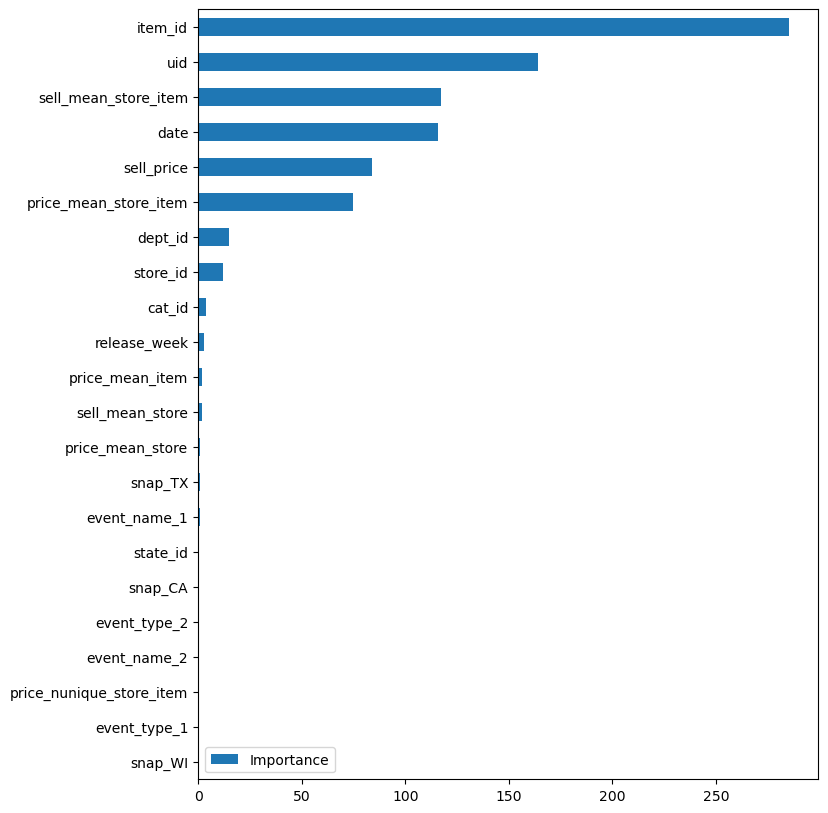

In [ ]:
CA = long[long['state_id']=='CA']
X = CA.drop(columns=['y'])
y = CA['y']
clf.fit(X, y, **fit_params)

feat_imp = pd.Series(clf.feature_importances_, index=Xca.columns)
feat_imp.sort_values(ascending=False, inplace=True)
df=pd.DataFrame(feat_imp)
df.sort_values(by=0, ascending=True, inplace=True)
df.rename(columns={0:'Importance'}, inplace=True)
df
df.plot(kind='barh', figsize=(8,10))

#### TX feature importance

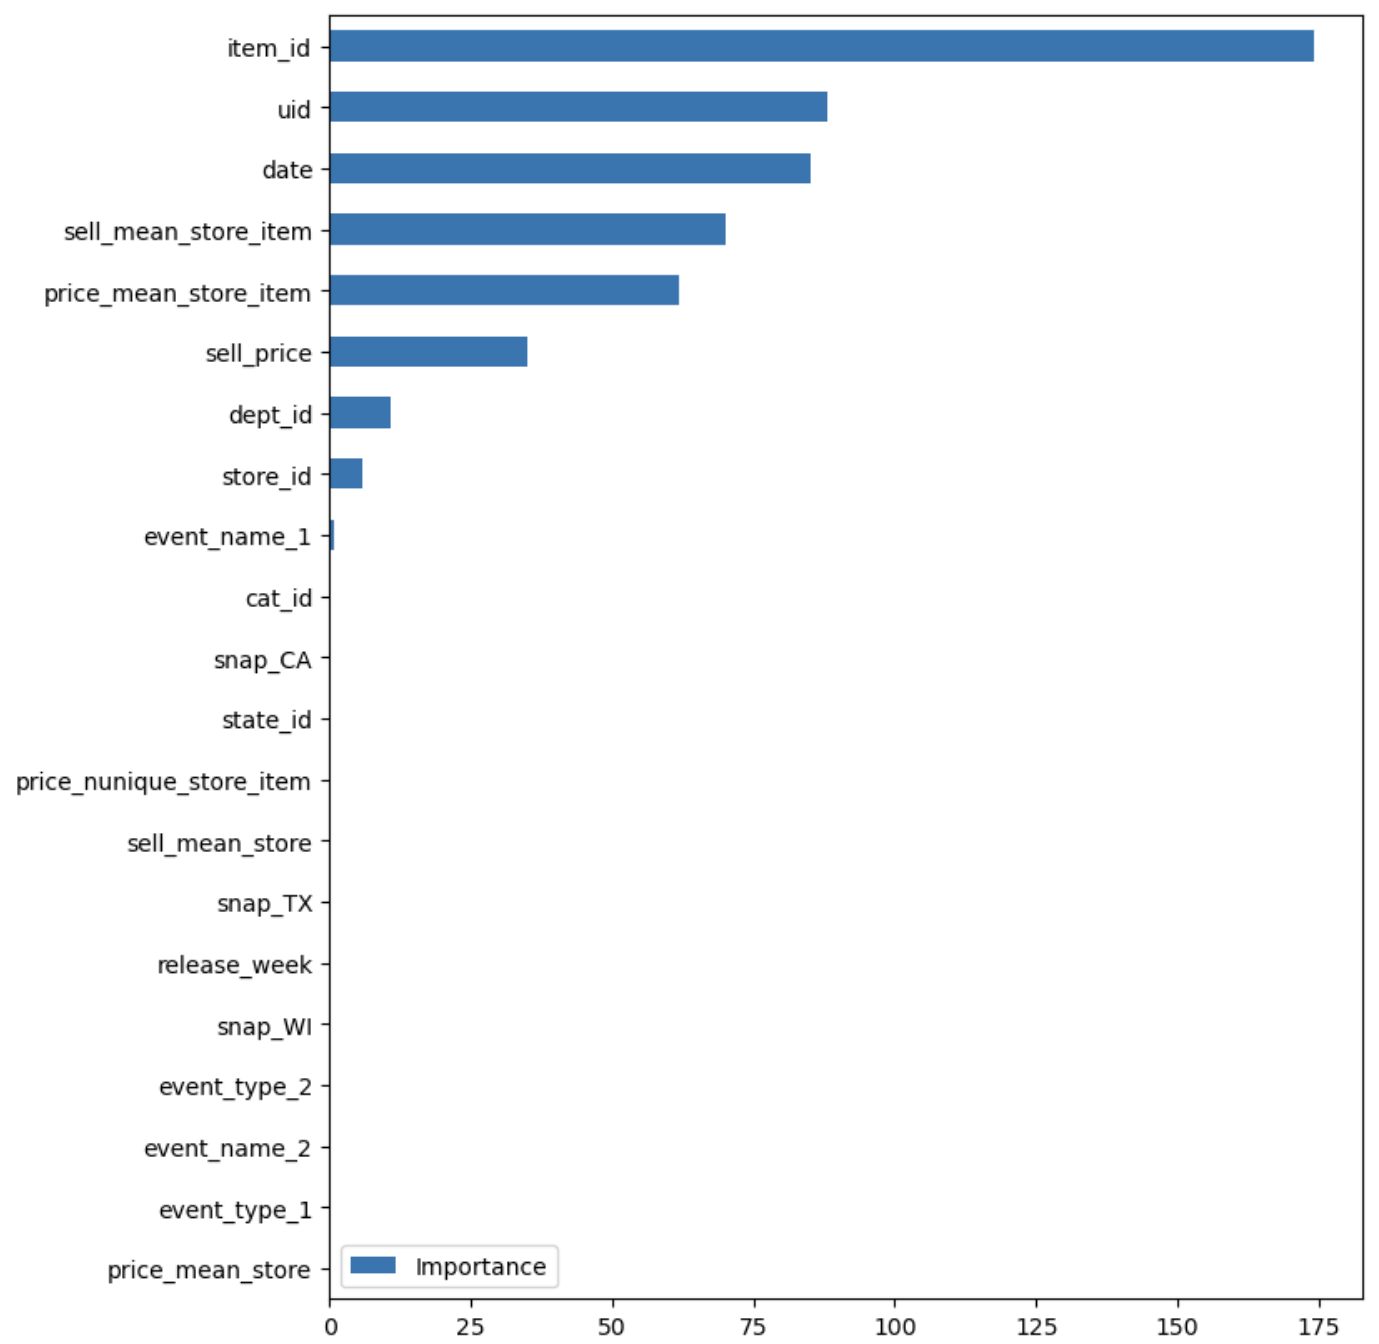

In [ ]:
from IPython.display import Image
Image("TX.png",width = 600, height = 700)

#### WI feature importance

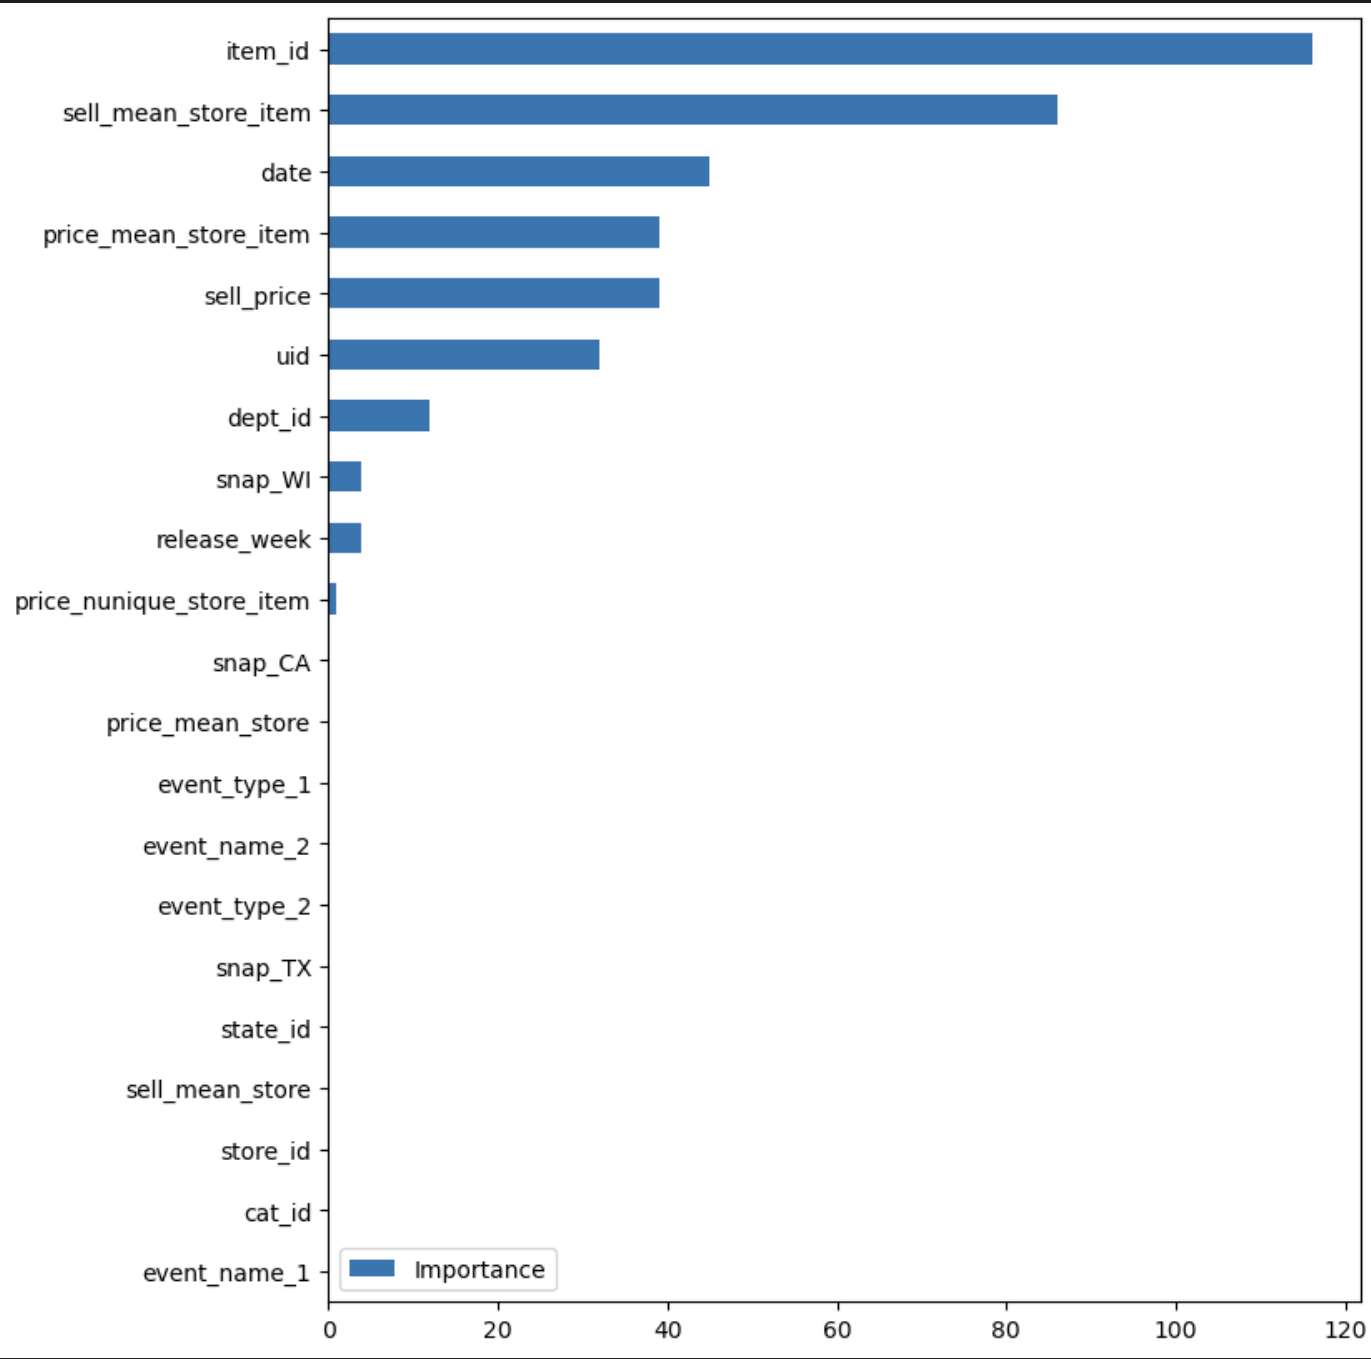

In [ ]:
from IPython.display import Image
Image("WI.png", width = 600, height = 700)

# 3. Modelling

**Hyperparameters Tuning:**

1. num_leaves: 128 / 256/ 512
2. n_estimators: 50 / 100 / 200
3. learning rate: 0.01 / 0.001

**Model Experiments:**
1. Original features, train by state
2. Original features, train by store
3. New features, train by state
4. New features, train by store
5. Ensemble model by combine four above

In [ ]:
# create rolling mean function
@njit
def rolling7d(x):
    return rolling_mean(x, window_size=7)

@njit
def rolling14d(x):
    return rolling_mean(x, window_size=14)

@njit
def rolling28d(x):
    return rolling_mean(x, window_size=28)

@njit
def seasonal_rolling_4w(x):
    return seasonal_rolling_mean(x, season_length=7, window_size=4)

After testing the hyper-parameters mentioned above, we found that:

- 'num_leaves': 256
- 'n_estimators': 50
- 'learning_rate': 0.01(default) 

performed the best in four different models

In [ ]:
model_params = {
    'verbose': -1,
    'force_col_wise': True,    
    'num_leaves': 256,
    'n_estimators': 50,
}

fcst = Forecast(
    models=[lgb.LGBMRegressor(**model_params)],
    freq='D',
    lags=[7 * (i+1) for i in range(8)],
    lag_transforms = {
        1:  [expanding_mean],
        7:  [rolling7d, rolling14d, rolling28d, seasonal_rolling_4w],
        14: [rolling7d, rolling14d, rolling28d, seasonal_rolling_4w],
        28: [rolling7d, rolling14d, rolling28d, seasonal_rolling_4w],
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],    
    num_threads=4,
)

In [ ]:
states = ['CA','WI','TX']
stores = ['CA_1','CA_2','CA_3','CA_4','WI_1','WI_2','WI_3','TX_1','TX_2','TX_3']

## Model Experiments

###　1. Original features, train by state
#### Private Score: **0.5640**

In [ ]:
df = pd.DataFrame()
for i in states:
    fcst.fit(
        old[old['state_id'] == i],
        id_col='index',
        time_col='date',
        target_col='y',
        static_features=['uid', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    )
    preds = fcst.predict(28, dynamic_dfs=[future_cal, future_prices])
    temp = preds.reset_index().pivot_table(index='id', columns='date')
    temp.columns = [f'F{i+1}' for i in range(28)]
    temp.columns.name = None
    temp.index.name = 'id'
    df = df.append(temp)
df.reset_index(inplace=True)

###　2. Original features, train by store
#### Private Score: **0.5637**

In [ ]:
df2 = pd.DataFrame()
for i in stores:
    fcst.fit(
        old[old['store_id'] == i],
        id_col='index',
        time_col='date',
        target_col='y',
        static_features=['uid', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    )
    preds = fcst.predict(28, dynamic_dfs=[future_cal, future_prices])
    temp = preds.reset_index().pivot_table(index='id', columns='date')
    temp.columns = [f'F{i+1}' for i in range(28)]
    temp.columns.name = None
    temp.index.name = 'id'
    df2 = df2.append(temp)
df2.reset_index(inplace=True)

### 3. New features, train by state
#### Private Score: **0.5709**

In [ ]:
df3 = pd.DataFrame()
for i in states:
    fcst.fit(
        long[long['state_id'] == i],
        id_col='index',
        time_col='date',
        target_col='y',
        static_features=['uid', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    )
    preds = fcst.predict(28, dynamic_dfs=[future_cal_new, future_prices_new])
    temp = preds.reset_index().pivot_table(index='id', columns='date')
    temp.columns = [f'F{i+1}' for i in range(28)]
    temp.columns.name = None
    temp.index.name = 'id'
    df3 = df3.append(temp)
df3.reset_index(inplace=True)

### 4. New features, train by store
#### Private Score: **0.5663**

In [ ]:
df4 = pd.DataFrame()
for i in stores:
    fcst.fit(
        old[old['store_id'] == i],
        id_col='index',
        time_col='date',
        target_col='y',
        static_features=['uid', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    )
    preds = fcst.predict(28, dynamic_dfs=[future_cal_new, future_prices_new])
    temp = preds.reset_index().pivot_table(index='id', columns='date')
    temp.columns = [f'F{i+1}' for i in range(28)]
    temp.columns.name = None
    temp.index.name = 'id'
    df4 = df2.append(temp)
df4.reset_index(inplace=True)

### 5. Ensemble Model
#### Private Score: **0.5633**

In [ ]:
df5 = pd.DataFrame()
df5['id'] = df1['id']
df1.drop(columns=['id'], inplace=True)
df2.drop(columns=['id'], inplace=True)
df3.drop(columns=['id'], inplace=True)
df4.drop(columns=['id'], inplace=True)

conbine = 0.25*df1 + 0.25*df2 + 0.25*df3 + 0.25*df4
df5 = pd.concat([df5,combine], axis = 1)

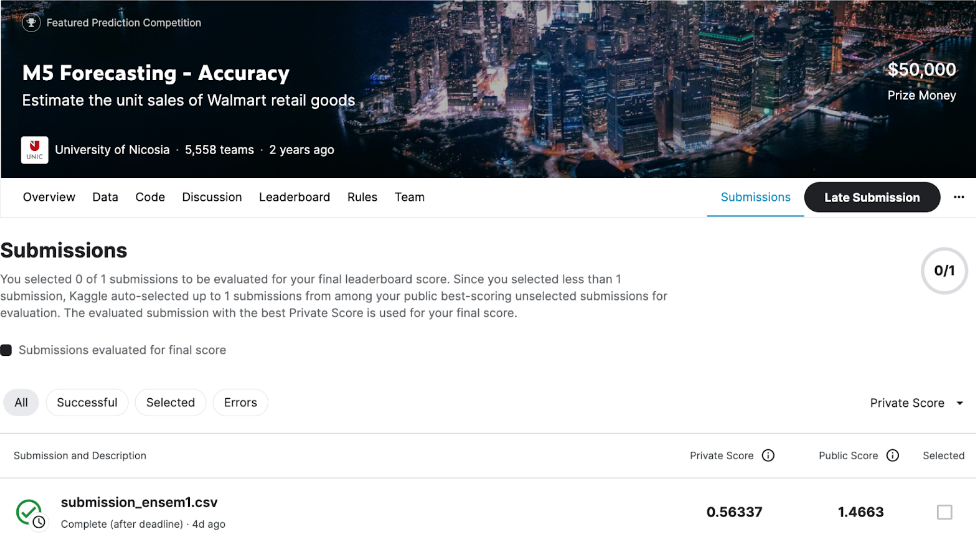

In [ ]:
from IPython.display import Image
Image("KAGGLE.png")

# Prepare Submission Format

Same procedure for each model, only show the code of submitting last model here 

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/submission.csv')
submission = pd.concat([submission, df5], axis=0)
submission.to_csv('ensemble.csv', index=False)

#### **Reference:**
1. https://www.kaggle.com/code/lemuz90/m5-mlforecast-eval
2. https://github.com/Jace-Yang/walmart-sales-forecasting/blob/master/main.ipynb
